<a href="https://colab.research.google.com/github/victoruwazurike1/Hamoye_Internship_Notebooks/blob/main/hamoye_wrangling_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv( "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv" ) 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
# Let us convert the Month column to datetime
df['Month'] = pd.to_datetime(df['Month'])

In [5]:
df.set_index('Month', inplace=True)

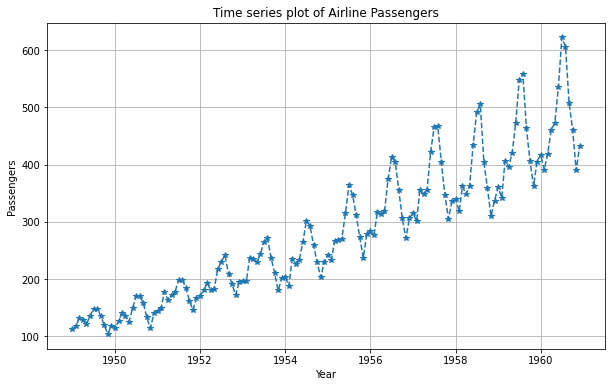

In [7]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df.Passengers, '--', marker = '*')
plt.grid()
plt.title('Time series plot of Airline Passengers')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.show()

In [9]:
# Let us check for missing values
df.isnull().values.any()

False